In [1]:
### can ignore, setting the home directory
import os
os.chdir('/content/drive/MyDrive/VQA_visually_challenged/notebooks (1)')

In [2]:
import numpy as np
import tensorflow as tf
import tensorflow_hub as hub
import scipy
from PIL import Image
from matplotlib.pyplot import imshow
import matplotlib.pyplot as plt

In [6]:
#metric for measuring quality performance
def srcc(y_true, y_pred):
     return ( tf.py_function(spearmanr, [tf.cast(y_pred, tf.float32),
                       tf.cast(y_true, tf.float32)], Tout = tf.float32) )

In [7]:
#preprocessing input image

IMG_SIZE = 448
CHANNELS = 3 

def test_img(filename, model):
    image_string = tf.io.read_file(filename)
    image_decoded = tf.image.decode_jpeg(image_string, channels=CHANNELS)
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    image_normalized = image_resized / 255.0
    pred = model.predict(np.array([image_normalized,]))
    return pred

In [8]:
#change the path to the test model
test_model = tf.keras.models.load_model('test-models/mliqa_resnet50_exp3.h5', custom_objects={'KerasLayer':hub.KerasLayer,'srcc':srcc}) ###path to the model

In [9]:
def feedback_both(img, model, test_img):
    im = Image.open(img)
    imshow(np.asarray(im))
    pred = test_img(img, model)
    qual = pred[1].item()
    dist = pred[0][0]
    print('Predicted global quality: ', qual)
    D = ['Blurry','Shaky','Bright','Dark','Grainy','None','Other']
    idx = np.argmax(dist)
    print('Most prominent distortion: ',D[idx])
    idx3 = dist.argsort()[-3:][::-1]
    print('Max 3 prominent distortions are: ', [D[i] for i in idx3])        
    print('All distortions: ')
    for i in range(7):
        print(D[i],': ',dist[i])

Predicted global quality:  0.431892991065979
Most prominent distortion:  Blurry
Max 3 prominent distortions are:  ['Blurry', 'Dark', 'Bright']
All distortions: 
Blurry :  0.30118456
Shaky :  0.15460047
Bright :  0.20719941
Dark :  0.22442695
Grainy :  0.15391254
None :  0.18484406
Other :  0.027541477


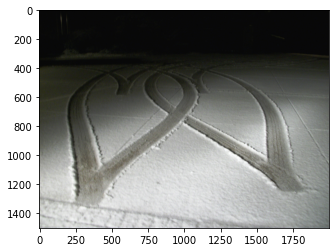

In [13]:
#change the path to test image
feedback_both('../test/VizWiz_test_00000581.jpg', test_model, test_img)

##Local Feedbacks and Maps

In [32]:
def test_patch(patch,model):
    image_decoded = tf.convert_to_tensor(patch)
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    image_normalized = image_resized / 255.0
    pred = model.predict(np.array([image_normalized,]))
    return pred


def qmap(img,h,w,Q_all):
    img = np.asarray(img)
    H,W,k = img.shape
    M = H//h
    N = W//w
    Q = np.empty([M,N])
    for i in range(M):
        for j in range(N):
            I = img[i:(i+1)*h,j:(j+1)*w,:]
            pred = test_patch(I, test_model)[1].item()
            Q[i,j] = pred
    return Q
  
def dmap(img,h,w,test_model,d):
    img = np.asarray(img)
    H,W,k = img.shape
    M = H//h
    N = W//w
    Q = np.empty([M,N])
    for i in range(M):
        for j in range(N):
            I = img[i:(i+1)*h,j:(j+1)*w,:]
            pred = test_patch(I, test_model)[0][0][d]
            Q[i,j] = pred
    return Q

def dmap_3(img,test_model,d):
    img = np.asarray(img)
    H,W,k = img.shape
    m = H//3
    n = W//3
    Q = np.empty([3,3])
    for i in range(3):
        for j in range(3):
            I = img[i:(i+1)*m,j:(j+1)*n,:]
            pred = test_patch(I, test_model)[0][0][d]
            Q[i,j] = pred
    return Q

def test_patch(patch,model):
    image_decoded = tf.convert_to_tensor(patch)
    image_resized = tf.image.resize(image_decoded, [IMG_SIZE, IMG_SIZE])
    image_normalized = image_resized / 255.0
    pred = model.predict(np.array([image_normalized,]))
    return pred

def plot_maps(image,Q):
    fig, axes = plt.subplots(1, 3, figsize=(12, 8 * 3))
    img = np.asarray(image)
    H, W, k = img.shape
    h, w = Q.shape  # self.mat.size()
    extent = (0, W // w * w, H // h * h, 0)

    # img = Image.fromarray(img.astype(np.uint8))
    axes[0].imshow(img)

    axes[1].imshow(Q, alpha=0.8, cmap='magma',
                   extent=extent, interpolation='bilinear')
    axes[2].imshow(Q, cmap='gray', extent=extent,
                   vmin=0, vmax=1)
    axes[2].set_title(f'Quality map {h}x{w}')
    return

def plot_dist_maps(image,Q):
    fig, axes = plt.subplots(1, 3, figsize=(12, 8 * 3))
    img = np.asarray(image)
    H, W, k = img.shape
    h, w = Q.shape  # self.mat.size()
    extent = (0, W // w * w, H // h * h, 0)

    # img = Image.fromarray(img.astype(np.uint8))
    axes[0].imshow(img)

    axes[1].imshow(Q, alpha=0.8, cmap='cividis',
                   extent=extent, interpolation='bilinear')
    axes[2].imshow(Q, cmap='gray', extent=extent,
                   vmin=0, vmax=1)
    axes[2].set_title(f'Distortion map {h}x{w}')
    return

def blend(Q, image, mos_range=(0, 100), alpha=0.8, resample=Image.BILINEAR):
        """qmap.blend().save('qmap.jpg')"""

        def stretch(image, minimum, maximum):
            if maximum is None:
                maximum = image.max()
            if minimum is None:
                minimum = image.min()
            image = (image - minimum) / (maximum - minimum)
            image[image < 0] = 0
            image[image > 1] = 1
            return image
        img = np.asarray(image)
        cm = plt.get_cmap('magma')
        # min-max normalize the image, you can skip this step
        qmap_matrix = 100*Q
        if mos_range is not None:
            qmap_matrix = 100*stretch(np.array(qmap_matrix), mos_range[0], mos_range[1])
        qmap_matrix = (np.array(qmap_matrix) * 255 / 100).astype(np.uint8)
        colored_map = cm(qmap_matrix)
        # Obtain a 4-channel image (R,G,B,A) in float [0, 1]
        # But we want to convert to RGB in uint8 and save it:
        heatmap = Image.fromarray((colored_map[:, :, :3] * 255).astype(np.uint8))
        
        sz = img.shape[1], img.shape[0]
        heatmap = heatmap.resize(sz, resample=resample)
        return Image.blend(image, heatmap, alpha=alpha)
    
def blend_dist(Q, image, mos_range=(0, 100), alpha=0.8, resample=Image.BILINEAR):
        """qmap.blend().save('qmap.jpg')"""

        def stretch(image, minimum, maximum):
            if maximum is None:
                maximum = image.max()
            if minimum is None:
                minimum = image.min()
            image = (image - minimum) / (maximum - minimum)
            image[image < 0] = 0
            image[image > 1] = 1
            return image
        img = np.asarray(image)
        cm = plt.get_cmap('cividis')
        # min-max normalize the image, you can skip this step
        qmap_matrix = 100*Q
        if mos_range is not None:
            qmap_matrix = 100*stretch(np.array(qmap_matrix), mos_range[0], mos_range[1])
        qmap_matrix = (np.array(qmap_matrix) * 255 / 100).astype(np.uint8)
        colored_map = cm(qmap_matrix)
        # Obtain a 4-channel image (R,G,B,A) in float [0, 1]
        # But we want to convert to RGB in uint8 and save it:
        heatmap = Image.fromarray((colored_map[:, :, :3] * 255).astype(np.uint8))
        
        sz = img.shape[1], img.shape[0]
        heatmap = heatmap.resize(sz, resample=resample)
        return Image.blend(image, heatmap, alpha=alpha)

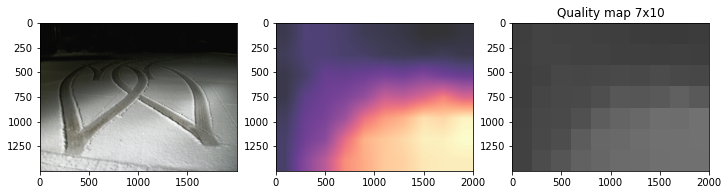

In [27]:
### Quality Map
img_file = '../test/VizWiz_test_00000581.jpg' ## path to the image
image = Image.open(img_file)
Q = qmap(image,200,200,test_model) ## change the patch size accordingly for finer or coarser maps
plot_maps(image,Q)

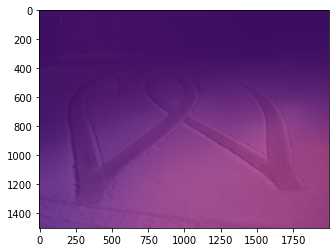

In [15]:
# blended map
I = blend(Q,image)
imshow(np.asarray(I))

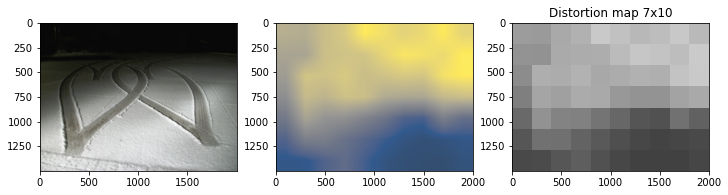

In [29]:
# vary patch size (here 200x200) and plot the distortion needed 0-BLR, 1-SHK, 2-BRT, 3-DRK, 4-GRN, 5-NON 
image = Image.open(img_file)
Q = dmap(image,200,200,test_model,3)
plot_dist_maps(image,Q)

#patch size could be set to 10% of img dimensions

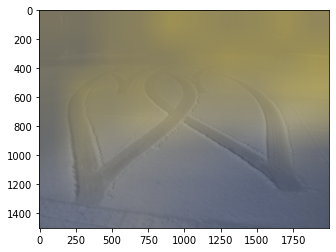

In [30]:
#blended distortion map
I = blend_dist(Q,image)
imshow(np.asarray(I))

[[0.68475997 0.75067544 0.79250228]
 [0.51035398 0.32363197 0.37186509]
 [0.27355957 0.18439598 0.21805349]]


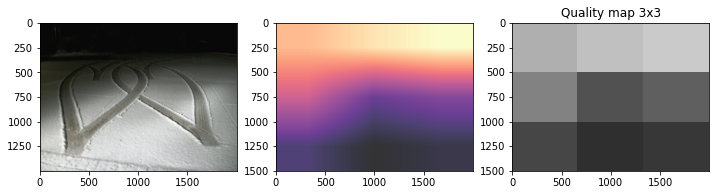

In [34]:
## 3x3 local distortion maps, type of distortion can be changed same as before
image = Image.open(img_file)
Q = dmap_3(image,test_model,3)
plot_maps(image,Q)
print(Q)